In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Object masks from prompts with SAM

The Segment Anything Model (SAM) predicts object masks given prompts that indicate the desired object. The model first converts the image into an image embedding that allows high quality masks to be efficiently produced from a prompt. 

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

## Environment Set-up

First install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository.

Before proceeding, please make sure that SAM has been [installed correctly](https://github.com/facebookresearch/segment-anything).

In [1]:
import sys
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

PyTorch version: 2.0.0+cu117
Torchvision version: 0.15.1+cu117
CUDA is available: True


## Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2


In [4]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


## Example image

In [27]:
image = cv2.imread('images/dog_car.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

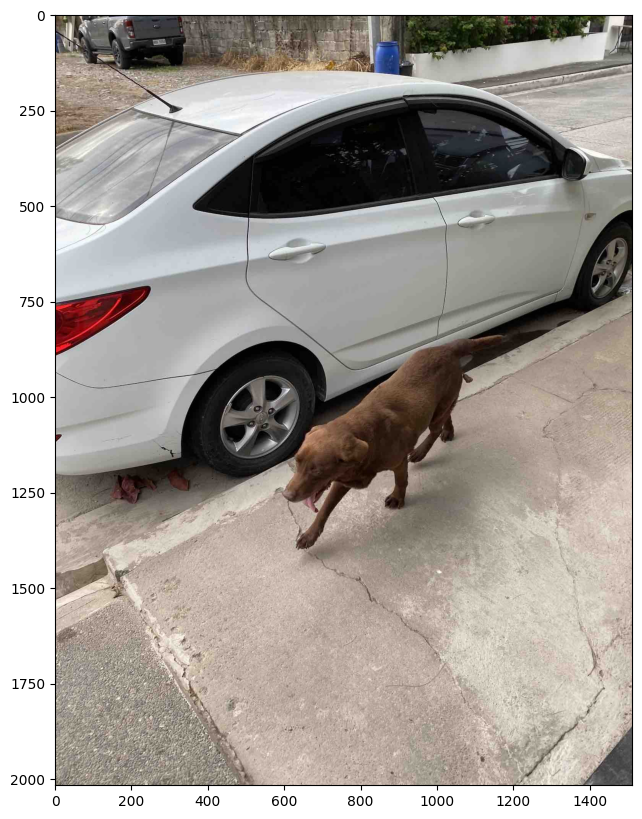

In [28]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.show()

## Selecting objects with SAM

First, load the SAM model and predictor. Change the path below to point to the SAM checkpoint. Running on CUDA and using the default model are recommended for best results.

In [29]:
import sys
import os
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = os.path.join("checkpoints", "sam_vit_h_4b8939.pth")

model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

Process the image to produce an image embedding by calling `SamPredictor.set_image`. `SamPredictor` remembers this embedding and will use it for subsequent mask prediction.

In [30]:
predictor.set_image(image)

To select the right coke can, select a point on it. Points are input to the model in (x,y) format and come with labels 1 (foreground point) or 0 (background point). Multiple points can be input; here we use only one. The chosen point will be shown as a star on the image.

In [31]:
input_point = np.array([[500, 1000]])
input_label = np.array([1])

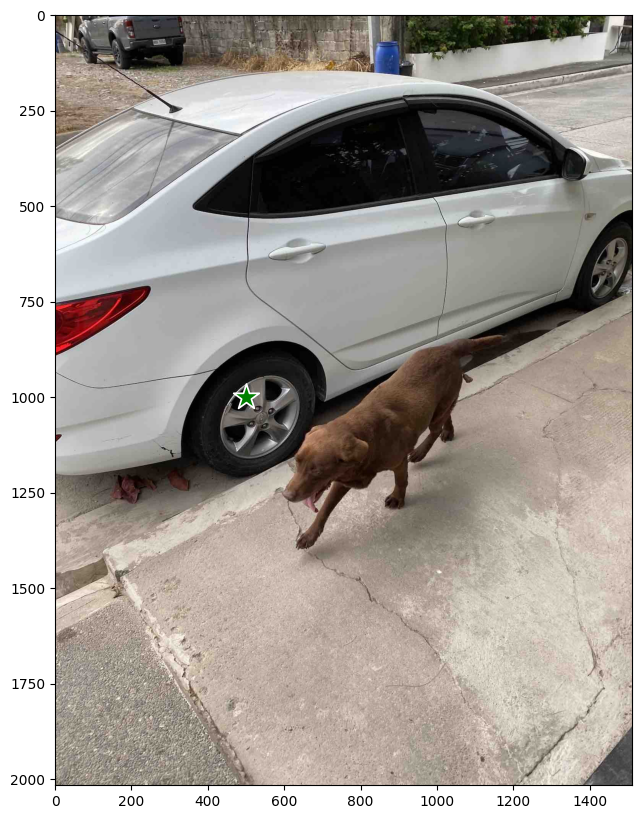

In [32]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

Predict with `SamPredictor.predict`. The model returns masks, quality predictions for those masks, and low resolution mask logits that can be passed to the next iteration of prediction.

In [33]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

With `multimask_output=True` (the default setting), SAM outputs 3 masks, where `scores` gives the model's own estimation of the quality of these masks. This setting is intended for ambiguous input prompts, and helps the model disambiguate different objects consistent with the prompt. When `False`, it will return a single mask. For ambiguous prompts such as a single point, it is recommended to use `multimask_output=True` even if only a single mask is desired; the best single mask can be chosen by picking the one with the highest score returned in `scores`. This will often result in a better mask.

In [34]:
masks.shape  # (number_of_masks) x H x W

(3, 2016, 1512)

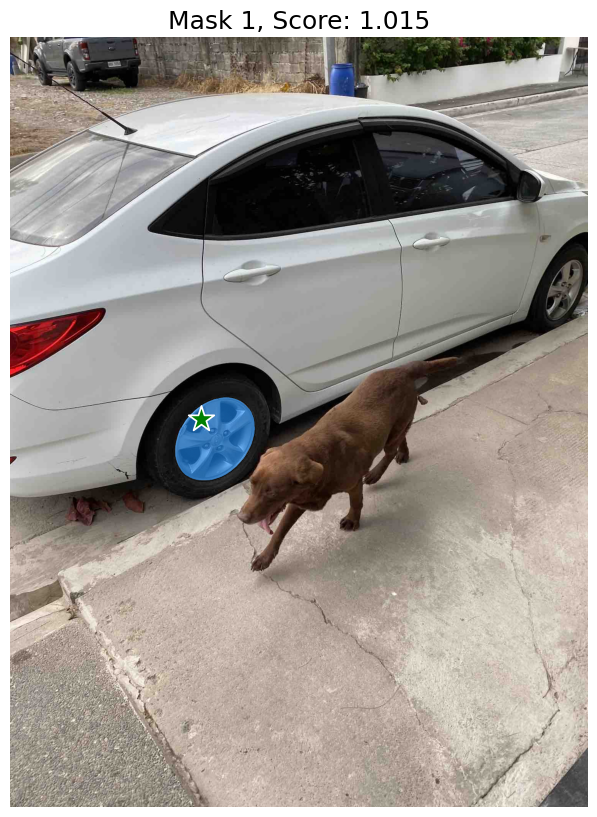

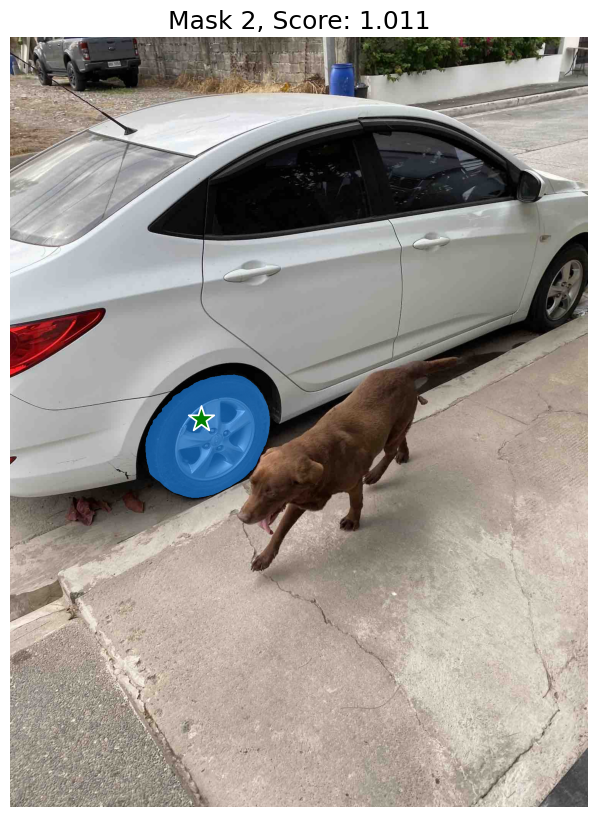

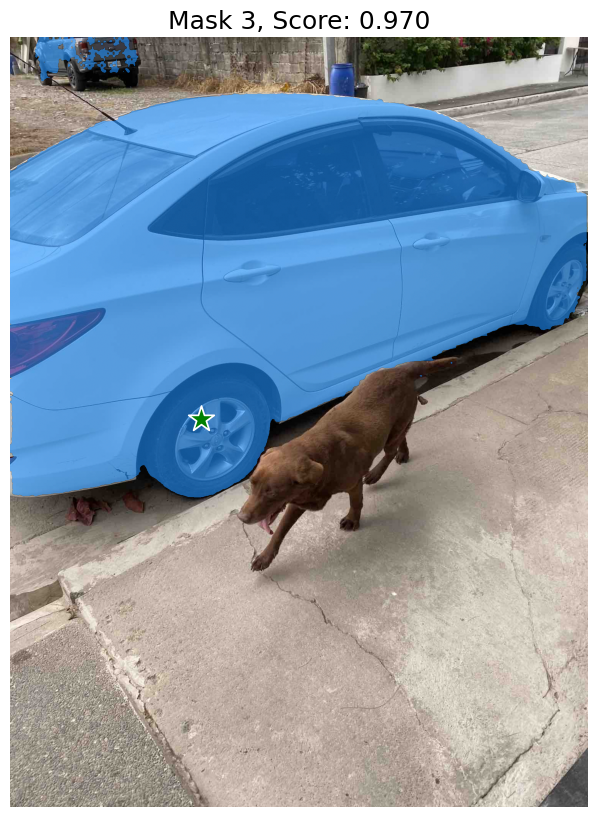

In [35]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  
  

## Specifying a specific object with additional points

The single input point is ambiguous, and the model has returned multiple objects consistent with it. To obtain a single object, multiple points can be provided. If available, a mask from a previous iteration can also be supplied to the model to aid in prediction. When specifying a single object with multiple prompts, a single mask can be requested by setting `multimask_output=False`.

In [40]:
input_point = np.array([[500, 1000], [1200, 750]])
input_label = np.array([1, 1])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [41]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

In [42]:
masks.shape

(1, 2016, 1512)

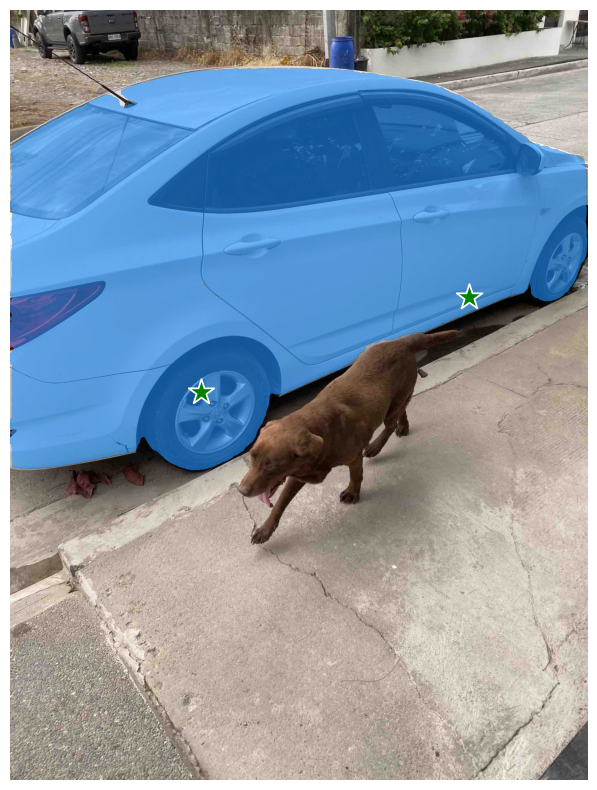

In [43]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 

To exclude the car and specify just the window, a background point (with label 0, here shown in red) can be supplied.

In [44]:
input_point = np.array([[500, 1000], [1200, 750]])
input_label = np.array([1, 0])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [45]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

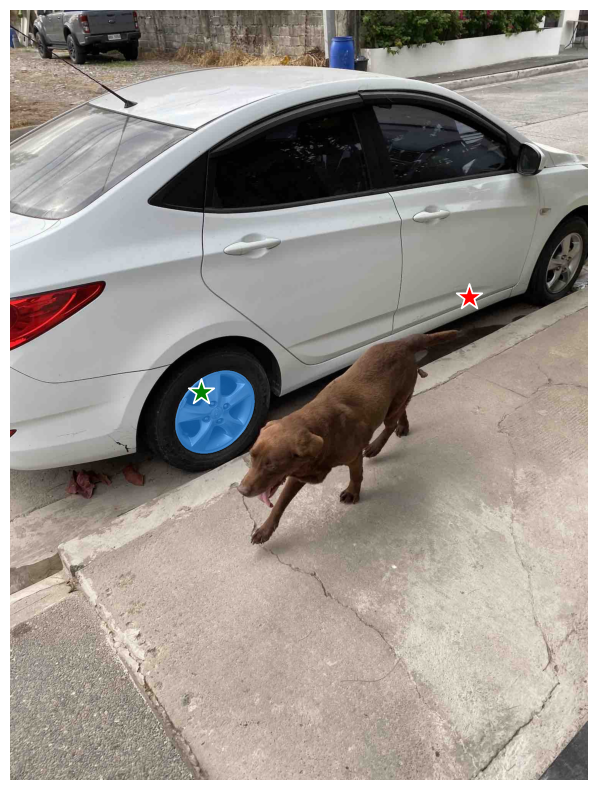

In [46]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 

## Specifying a specific object with a box

The model can also take a box as input, provided in xyxy format. For example, if a box is drawn around the dog, the model will predict a mask for the dog.

In [60]:
input_box = np.array([600, 850, 1200, 1400])

In [61]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

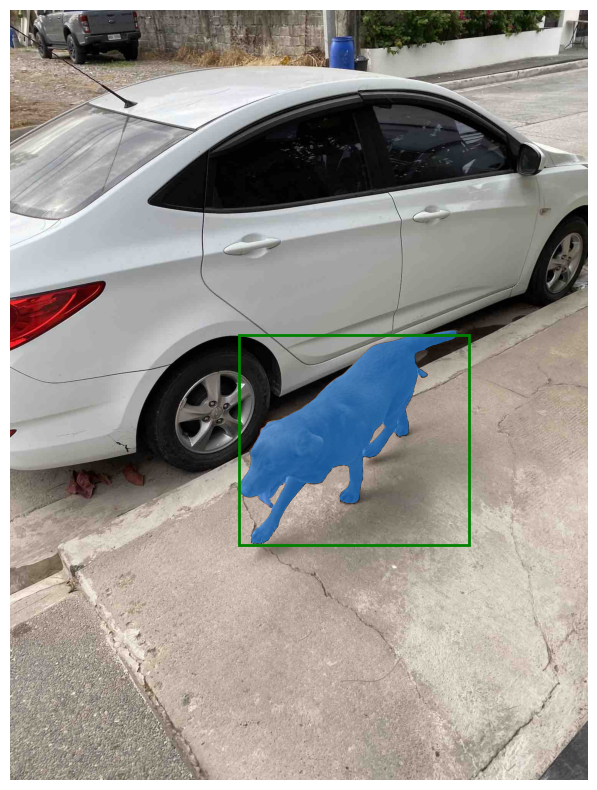

In [62]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

## Combining points and boxes

Points and boxes may be combined, just by including both types of prompts to the predictor. Here this can be used to select just the trucks's tire, instead of the entire wheel.

In [78]:
input_box = np.array([360, 875, 700, 1200])
input_point = np.array([[500, 1000]])
input_label = np.array([0])

In [79]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box=input_box,
    multimask_output=False,
)

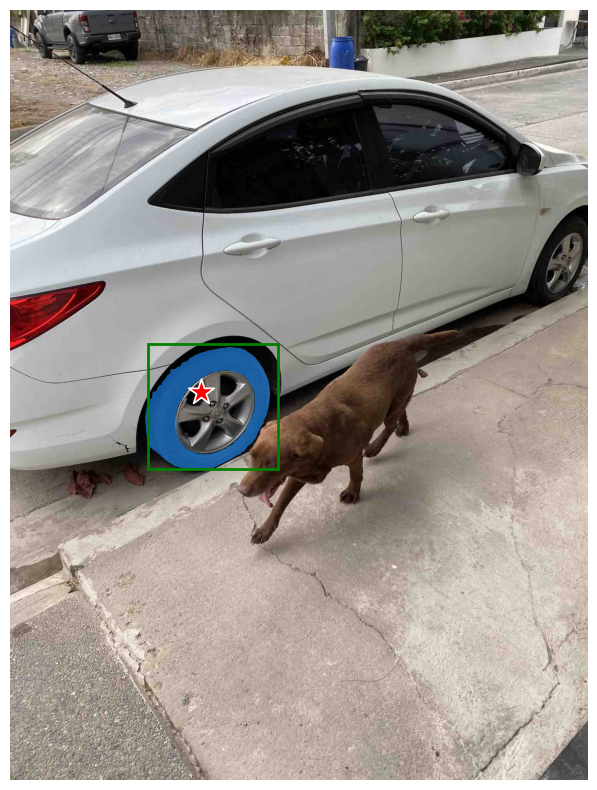

In [80]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()